In [2]:
import torch
import os
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn.init as init

### Carregando MotionSense Dataset

In [3]:
path = 'dataset/motion_sense/A_DeviceMotion_data/A_DeviceMotion_data/'

list_of_folders = os.listdir(path)
list_of_directories = [path + i for i in list_of_folders]
list_of_directories = [s for s in list_of_directories if '.DS_Store' not in s]
list_of_dfs = []

activities = ['dws', 'ups', 'sit', 'std', 'wlk', 'jog']

# Iterating through the directories and appending the dataframes for each subject in each of the trials to a list for further use.

for i in list_of_directories:
    list_of_csv = os.listdir(i)
    for j in list_of_csv:
        k = pd.read_csv(i + '/' + j).rename(columns={'Unnamed: 0': 'time'})
        k['subject'] = int(j.split('_')[1].split('.')[0])
        k['activity'] = i.split('/')[4].split('_')[0]
        k['trial'] = int(i.split('/')[4].split('_')[1])
        k.insert(0, 'accel_x', k['userAcceleration.x'] + k['gravity.x'])
        k.insert(1, 'accel_y', k['userAcceleration.y'] + k['gravity.y'])
        k.insert(2, 'accel_z', k['userAcceleration.z'] + k['gravity.z'])
        k.insert(3, 'accel_norm', np.sqrt(k['accel_x']**2 + k['accel_y']**2 + k['accel_z']**2))
        list_of_dfs.append(k)

# Creating one big dataframe (df) from the list of all individual dataframes. Dropping unnecessary columns and renaming the ones for rotation.

df = pd.concat(list_of_dfs).set_index('time')
df = df.drop(['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x', 'gravity.y', 'gravity.z', 'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z'], axis=1)
df = df.rename(columns={'rotationRate.x': 'gyro_x', 'rotationRate.y': 'gyro_y', 'rotationRate.z': 'gyro_z'})

df.drop(columns=['accel_norm', 'subject'], inplace=True)

In [4]:
df

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,activity,trial
time,,,,,,,,
0,-0.122085,0.626434,-0.161957,-1.264215,-1.027909,-0.947909,dws,11
1,-0.160369,0.946457,-0.288605,-1.162024,-0.269118,-0.848823,dws,11
2,-0.178482,1.202301,-0.178314,-0.665042,0.520170,-0.726722,dws,11
3,-0.033493,1.307663,-0.223786,-0.079809,0.055322,-0.604534,dws,11
4,-0.141067,1.322677,-0.641449,0.456097,-0.186877,-0.441315,dws,11
...,...,...,...,...,...,...,...,...
7019,0.102691,0.958511,0.061721,-0.085002,-0.429722,-0.069257,std,6
7020,0.111344,0.991745,0.002258,-0.135020,-0.400788,-0.068575,std,6
7021,0.058075,0.992142,-0.000717,-0.183880,-0.342070,-0.058310,std,6


In [5]:
def create_lag_features(df, n, cols):
    """

    Parameters
    ----------
    n : int
        amount of lag features
    cols : list
        list of columns to lag

    Returns
    -------
    pd.DataFrame
        a dataframe with the list of columns lagged n times

    """

    lag_features = n
    lag_dfs = [df]

    for col in cols:
        for lag in range(1, lag_features + 1):
            lagged = df[col].shift(lag)
            lagged.name = f'{col}_lag{lag}'
            lag_dfs.append(lagged)
    
    lag_df = pd.concat(lag_dfs, axis=1)
    lag_df = lag_df.drop(range(lag_features))
    lag_df = lag_df.sort_index(axis=1)
    return lag_df

In [6]:
colunas = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
lag_df = create_lag_features(df, 59, colunas)
lag_df.head()

,accel_x,accel_x_lag1,accel_x_lag10,accel_x_lag11,accel_x_lag12,accel_x_lag13,accel_x_lag14,accel_x_lag15,accel_x_lag16,accel_x_lag17,...,gyro_z_lag55,gyro_z_lag56,gyro_z_lag57,gyro_z_lag58,gyro_z_lag59,gyro_z_lag6,gyro_z_lag7,gyro_z_lag8,gyro_z_lag9,trial
time,,,,,,,,,,,,,,,,,,,,,
59,-0.168045,-0.199096,-0.037857,-0.294998,-0.212998,0.083634,0.214600,-0.438645,-0.185638,-0.502411,...,-0.441315,-0.604534,-0.726722,-0.848823,-0.947909,0.411301,0.495083,0.543111,0.144933,11
60,-0.156754,-0.168045,-0.040817,-0.037857,-0.294998,-0.212998,0.083634,0.214600,-0.438645,-0.185638,...,-0.563895,-0.441315,-0.604534,-0.726722,-0.848823,-0.124268,0.411301,0.495083,0.543111,11
61,0.006927,-0.156754,-0.051727,-0.040817,-0.037857,-0.294998,-0.212998,0.083634,0.214600,-0.438645,...,-0.275566,-0.563895,-0.441315,-0.604534,-0.726722,-0.513775,-0.124268,0.411301,0.495083,11
62,0.012893,0.006927,-0.185211,-0.051727,-0.040817,-0.037857,-0.294998,-0.212998,0.083634,0.214600,...,0.175475,-0.275566,-0.563895,-0.441315,-0.604534,-0.563348,-0.513775,-0.124268,0.411301,11
63,-0.076065,0.012893,-0.589951,-0.185211,-0.051727,-0.040817,-0.037857,-0.294998,-0.212998,0.083634,...,0.582617,0.175475,-0.275566,-0.563895,-0.441315,-0.637314,-0.563348,-0.513775,-0.124268,11


In [7]:
# pegando só 10% das amostras
df_90, df_10 = train_test_split(lag_df, test_size=0.1, random_state=42) # dataframes de treino e validacao
lag_df = df_10

In [8]:
# pegando só 10% das amostras
lag_df.head()

,accel_x,accel_x_lag1,accel_x_lag10,accel_x_lag11,accel_x_lag12,accel_x_lag13,accel_x_lag14,accel_x_lag15,accel_x_lag16,accel_x_lag17,...,gyro_z_lag55,gyro_z_lag56,gyro_z_lag57,gyro_z_lag58,gyro_z_lag59,gyro_z_lag6,gyro_z_lag7,gyro_z_lag8,gyro_z_lag9,trial
time,,,,,,,,,,,,,,,,,,,,,
2261,0.538239,0.537826,0.538742,0.538697,0.536926,0.540191,0.537567,0.537476,0.534561,0.537400,...,-0.000554,-0.000613,-0.001655,-0.000583,0.000470,0.000424,-0.000644,0.000404,0.000392,13
3808,-0.256195,-0.267868,-0.259079,-0.257797,-0.257843,-0.251495,-0.254288,-0.255997,-0.256470,-0.257676,...,0.000214,0.003420,0.002222,-0.001005,-0.002081,0.000658,0.001702,0.002787,0.002749,6
504,0.846481,0.577744,0.298142,0.287247,0.408538,0.540055,0.678421,0.762390,0.706910,0.716065,...,-0.514370,0.023858,0.437574,0.706296,1.111067,1.453131,1.287785,0.916912,0.454764,2
4360,0.322860,0.244294,-0.312241,-0.477737,-0.297165,-0.231170,-0.184159,-0.050766,0.151947,0.158218,...,-0.259899,0.167511,0.110542,-0.200915,-0.610521,-0.666095,-0.956987,-1.110109,-1.143580,7
4230,0.251542,0.210739,-0.037597,0.364257,0.687149,0.289124,-0.196900,-0.405350,-0.093032,-0.044418,...,0.007735,-0.126143,-0.193275,-0.152815,-0.054737,0.178779,0.119767,0.046266,0.000403,8


In [9]:
lag_df.shape

(139163, 362)

In [10]:
train = lag_df[(lag_df.trial < 10)]
test = lag_df[(lag_df.trial > 10)]

In [11]:
train_df, val_df = train_test_split(train, test_size=0.3, random_state=42) # dataframes de treino e validacao

In [12]:
print(train_df.shape, val_df.shape)

(74914, 362) (32107, 362)


In [13]:
X_train = train_df.drop(columns=['trial', 'activity'])
y_train = train_df.activity
X_test = test.drop(columns=['trial', 'activity'])
y_test = test.activity
X_val = val_df.drop(columns=['trial', 'activity'])
y_val = val_df.activity

In [14]:
atividades = {
    'jog': 0, 
    'ups': 1, 
    'std': 2, 
    'wlk': 3, 
    'sit': 4, 
    'dws': 5,
}
y_train = y_train.map(atividades)
y_test = y_test.map(atividades)
y_val = y_val.map(atividades)

In [15]:
print(train.shape, test.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(107021, 362) (32142, 362)
(74914, 360) (74914,)
(32142, 360) (32142,)
(32107, 360) (32107,)


### Carregando UCI-HAR Dataset

In [2]:
train_original = pd.read_csv('dataset/hars/train.csv')
df_test = pd.read_csv('dataset/hars/test.csv') # dataframe de teste

df_train, df_val = train_test_split(train_original, test_size=0.2, random_state=42) # dataframes de treino e validacao

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

# removendo coluna subject e Activity
df_train.drop(columns=['subject', 'Activity'], inplace=True)
df_test.drop(columns=['subject', 'Activity'], inplace=True)
df_val.drop(columns=['subject', 'Activity'], inplace=True)

colunas = [
    'tBodyAcc-mean()-X',
    'tBodyAcc-mean()-Y',
    'tBodyAcc-mean()-Z',
    'tBodyGyro-std()-X',
    'tBodyGyro-std()-Y',
    'tBodyGyro-std()-Z',
]
df_train = df_train[colunas]
df_test = df_test[colunas]
df_val = df_val[colunas]

print("shape train: ", df_train.shape)
print("shape test: ", df_test.shape)
print("shape valid: ", df_val.shape)

shape train:  (5881, 6)
shape test:  (2947, 6)
shape valid:  (1471, 6)


In [3]:
df_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z
0,0.278007,-0.017803,-0.108965,-0.998972,-0.994455,-0.986156
1,0.237617,-0.000782,-0.114476,-0.615275,-0.505425,0.107848
2,0.290924,-0.050878,-0.073518,-0.518926,0.179382,-0.482520
3,0.275268,-0.015050,-0.114204,-0.857124,-0.934673,-0.885010
4,0.278790,-0.018585,-0.106908,-0.978211,-0.987178,-0.985936


In [4]:
def create_lag_features(df, n, cols):
    """

    Parameters
    ----------
    n : int
        amount of lag features
    cols : list
        list of columns to lag

    Returns
    -------
    pd.DataFrame
        a dataframe with the list of columns lagged n times

    """

    lag_features = n
    lag_dfs = [df]

    for col in cols:
        for lag in range(1, lag_features + 1):
            lagged = df[col].shift(lag)
            lagged.name = f'{col}_lag{lag}'
            lag_dfs.append(lagged)
    
    lag_df = pd.concat(lag_dfs, axis=1)
    lag_df = lag_df.drop(range(lag_features))
    lag_df = lag_df.sort_index(axis=1)
    return lag_df

In [5]:
X_train = create_lag_features(df_train, 59, colunas)
X_test = create_lag_features(df_test, 59, colunas)
X_val = create_lag_features(df_val, 59, colunas)

In [6]:
print("shape train: ", X_train.shape)
print("shape test: ", X_test.shape)
print("shape valid: ", X_val.shape)

shape train:  (5822, 360)
shape test:  (2888, 360)
shape valid:  (1412, 360)


In [7]:
X_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-X_lag1,tBodyAcc-mean()-X_lag10,tBodyAcc-mean()-X_lag11,tBodyAcc-mean()-X_lag12,tBodyAcc-mean()-X_lag13,tBodyAcc-mean()-X_lag14,tBodyAcc-mean()-X_lag15,tBodyAcc-mean()-X_lag16,tBodyAcc-mean()-X_lag17,...,tBodyGyro-std()-Z_lag54,tBodyGyro-std()-Z_lag55,tBodyGyro-std()-Z_lag56,tBodyGyro-std()-Z_lag57,tBodyGyro-std()-Z_lag58,tBodyGyro-std()-Z_lag59,tBodyGyro-std()-Z_lag6,tBodyGyro-std()-Z_lag7,tBodyGyro-std()-Z_lag8,tBodyGyro-std()-Z_lag9
59,0.327465,0.246977,0.279570,0.274985,0.274527,0.266437,0.223646,0.500716,0.329740,0.231415,...,-0.185148,-0.985936,-0.885010,-0.482520,0.107848,-0.986156,-0.990610,-0.535644,-0.173436,-0.996733
60,0.364806,0.327465,0.275539,0.279570,0.274985,0.274527,0.266437,0.223646,0.500716,0.329740,...,-0.840699,-0.185148,-0.985936,-0.885010,-0.482520,0.107848,-0.988617,-0.990610,-0.535644,-0.173436
61,0.275929,0.364806,0.214747,0.275539,0.279570,0.274985,0.274527,0.266437,0.223646,0.500716,...,-0.960914,-0.840699,-0.185148,-0.985936,-0.885010,-0.482520,-0.995491,-0.988617,-0.990610,-0.535644
62,0.304035,0.275929,0.272286,0.214747,0.275539,0.279570,0.274985,0.274527,0.266437,0.223646,...,-0.220107,-0.960914,-0.840699,-0.185148,-0.985936,-0.885010,-0.991802,-0.995491,-0.988617,-0.990610
63,0.331172,0.304035,0.281490,0.272286,0.214747,0.275539,0.279570,0.274985,0.274527,0.266437,...,-0.482335,-0.220107,-0.960914,-0.840699,-0.185148,-0.985936,-0.995414,-0.991802,-0.995491,-0.988617


### Transforms

In [16]:
class Jitter:
    def __init__(self, sigma=0.01):
        self.sigma = sigma

    def __call__(self, x):
        noise = np.random.normal(loc=0, scale=self.sigma, size=x.shape)
        return x + noise

class Scaling:
    def __init__(self, sigma=0.1):
        self.sigma = sigma

    def __call__(self, x):
        factor = np.random.normal(loc=1.0, scale=self.sigma)
        return x * factor

class TimeShift:
    def __init__(self, max_shift=50):
        self.max_shift = max_shift

    def __call__(self, x):
        shift = np.random.randint(-self.max_shift, self.max_shift)
        return np.roll(x, shift)

# classe de transformacoes nos dados
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x):
        for t in self.transforms:
            if callable(t):
                x = t(x)
            else:
                x = t.fit_transform(x)
        return x

### Carregando Dataset

In [17]:
class CSVDataset(Dataset):
    def __init__(self, df, transform=None):
        self.data = df
        self.transform = transform

        if self.transform:
            self.features = self.transform(self.data)
        else:
            self.features = self.data
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        sample = torch.tensor(self.features[idx], dtype=torch.float32).unsqueeze(0)
        return sample

In [18]:
def createDataLoader(X_train, X_test, batch_size=32):
    # scaler = StandardScaler()
    train_transform = Compose([
        StandardScaler(),
        Jitter(),
        Scaling(),
        TimeShift()
    ])
    valid_test_transform = Compose([
        StandardScaler()
    ])

    train_dataset = CSVDataset(X_train, transform=train_transform)
    test_dataset = CSVDataset(X_test, transform=valid_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_dataset, test_dataset, train_loader, test_loader

In [19]:
train_dataset, test_dataset, train_loader, test_loader = createDataLoader(X_train.values, X_test.values)

In [20]:
print(len(train_dataset), len(train_loader), len(test_loader))

74914 2342 1005


In [21]:
for x in train_loader:
    print(x.shape) # (batch_size, seq_len, input_dim)
    break

torch.Size([32, 1, 360])


In [22]:
for batch_idx, batch in enumerate(train_loader):
    print(batch.shape)
    break

torch.Size([32, 1, 360])


In [32]:
class TemporalVAE(nn.Module):
    def __init__(self, device, input_dim, hidden_dim, latent_dim, num_layers=1):
        super(TemporalVAE, self).__init__()
        self.device = device

        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=0.2)
        self.hidden2mean = nn.Linear(hidden_dim, latent_dim)
        self.hidden2logvar = nn.Linear(hidden_dim, latent_dim)
        
        self.latent2hidden = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True, bidirectional=False, dropout=0.2)
        self.output_layer = nn.Linear(input_dim, input_dim)
        self.dropout = nn.Dropout(0.2)
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(self.device)
        return mean + eps * std
    
    def encode(self, x):
        residual = x
        output, (h_n, _) = self.encoder_lstm(x)
        output = output[:, :, :output.size(2)//2] + output[:, :, output.size(2)//2:]
        h_n = output[:, -1, :]
        # h_n = h_n[-1, :, :]
        h_n = self.dropout(h_n)
        mean = F.leaky_relu(input=self.hidden2mean(h_n), negative_slope=0.01) # sigmoid (obs: se usar relu vai zerar)
        logvar = F.leaky_relu(self.hidden2logvar(h_n), negative_slope=0.01) # sigmoid (obs: se usar relu vai zerar)
        return mean, logvar, residual
    
    def decode(self, z, seq_len, residual):
        # hidden = self.latent2hidden(z).unsqueeze(0).repeat(seq_len, 1, 1).transpose(0, 1)
        hidden = self.latent2hidden(z).unsqueeze(1).repeat(1, seq_len, 1)

        output, _ = self.decoder_lstm(hidden)
        output = self.dropout(output)

        # output += residual

        output = self.output_layer(output)
        return output
    
    def forward(self, x):
        mean, logvar, residual = self.encode(x)
        # print(mean)
        z = self.reparameterize(mean, logvar)
        seq_len = x.size(1)
        recon_x = self.decode(z, seq_len, residual)
        return recon_x, mean, logvar

In [33]:
# Definir parâmetros do modelo
input_dim = train_dataset.features.shape[1]
hidden_dim = 128 # 400
latent_dim = 64 # 20
num_layers = 2
learning_rate = 0.001
# batch_size = 32
epochs = 100

print(input_dim)

360


In [34]:
def loss_function(x, x_hat, mean, log_var):
    # reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum') # mse
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [35]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                init.orthogonal_(param.data)
            elif 'bias' in name:
                init.zeros_(param.data)

In [36]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cuda
device = torch.device('cpu') # essa linha só está aqui para fazer o model.apply() funcionar, porque tem uma funcao de inicializacao que nao funciona no MPS atualmente
print(device)

# model = VAE(input_dim, device).to(device) # baseline
model = TemporalVAE(device, input_dim, hidden_dim, latent_dim, num_layers).to(device)
model.apply(init_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

cpu


In [37]:
print(model)

TemporalVAE(
  (encoder_lstm): LSTM(360, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (hidden2mean): Linear(in_features=128, out_features=64, bias=True)
  (hidden2logvar): Linear(in_features=128, out_features=64, bias=True)
  (latent2hidden): Linear(in_features=64, out_features=128, bias=True)
  (decoder_lstm): LSTM(128, 360, num_layers=2, batch_first=True, dropout=0.2)
  (output_layer): Linear(in_features=360, out_features=360, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [38]:
def evaluate_metrics(x, recon_x):
    x = x.view(-1).detach().cpu().numpy()
    recon_x = recon_x.view(-1).detach().cpu().numpy()
    
    mse = mean_squared_error(x, recon_x)
    mae = mean_absolute_error(x, recon_x)
    rmse = mse ** 0.5
    r2 = r2_score(x, recon_x)
    
    return mse, mae, rmse, r2

def train_vae(model, train_loader, optimizer, device):
    model.train()
    overall_loss = 0
    mse_total = 0
    mae_total = 0
    rmse_total = 0
    r2_total = 0
    for x in train_loader:
        data = x.to(device)
        optimizer.zero_grad()
        x_hat, mean, log_var = model(data)
        loss = loss_function(data, x_hat, mean, log_var)
        loss.backward()
        optimizer.step()
        overall_loss += loss.item()
        mse, mae, rmse, r2 = evaluate_metrics(data, x_hat)
        mse_total += mse
        mae_total += mae
        rmse_total += rmse
        r2_total += r2
    avg_train_loss = overall_loss / len(train_loader.dataset)
    avg_mse = mse_total / len(train_loader.dataset)
    avg_mae = mae_total / len(train_loader.dataset)
    avg_rmse = rmse_total / len(train_loader.dataset)
    avg_r2 = r2_total / len(train_loader.dataset)
    return avg_train_loss, avg_mse, avg_mae, avg_rmse, avg_r2

def val_vae(model, val_loader, device):
    model.eval()
    overall_loss = 0
    mse_total = 0
    mae_total = 0
    rmse_total = 0
    r2_total = 0
    with torch.no_grad():
        for x in val_loader:
            data = x.to(device)
            x_hat, mean, log_var = model(data)
            loss = loss_function(data, x_hat, mean, log_var)
            overall_loss += loss.item()
            mse, mae, rmse, r2 = evaluate_metrics(data, x_hat)
            mse_total += mse
            mae_total += mae
            rmse_total += rmse
            r2_total += r2
    avg_val_loss = overall_loss / len(val_loader.dataset)
    avg_mse = mse_total / len(train_loader.dataset)
    avg_mae = mae_total / len(train_loader.dataset)
    avg_rmse = rmse_total / len(train_loader.dataset)
    avg_r2 = r2_total / len(train_loader.dataset)
    return avg_val_loss, avg_mse, avg_mae, avg_rmse, avg_r2

In [39]:
def train(model, optimizer, epochs, device):
    train_losses = []
    val_losses = []
    
    train_mse = []
    train_mae = []
    train_rmse = []
    train_r2 = []

    val_mse = []
    val_mae = []
    val_rmse = []
    val_r2 = []
    for epoch in range(epochs):
        train_loss, mse_train, mae_train, rmse_train, r2_train = train_vae(model=model, train_loader=train_loader, optimizer=optimizer, device=device)
        val_loss, mse_val, mae_val, rmse_val, r2_val = val_vae(model=model, val_loader=test_loader, device=device)
        train_losses.append(train_loss)
        train_mse.append(mse_train)
        train_mae.append(mae_train)
        train_rmse.append(rmse_train)
        train_r2.append(r2_train)

        val_losses.append(val_loss)
        val_mse.append(mse_val)
        val_mae.append(mae_val)
        val_rmse.append(rmse_val)
        val_r2.append(r2_val)
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train MSE: {mse_train}, Val MSE: {mse_val}, Train MAE: {mae_train}, Val MAE: {mae_val}, Val R2: {r2_val}')
    return train_losses, val_losses, val_losses, train_mse, train_mae, train_rmse, train_r2, val_mse, val_mae, val_rmse, val_r2

In [40]:
train_losses, val_losses, val_losses, train_mse, train_mae, train_rmse, train_r2, val_mse, val_mae, val_rmse, val_r2 = train(model, optimizer, epochs, device)

Epoch [1/100], Train Loss: 367.9505, Val Loss: 337.7023, Train MSE: 0.03043385737801329, Val MSE: 0.01210089384448106, Train MAE: 0.018315329105453606, Val MAE: 0.007957264185858813, Val R2: 0.001311845422430772
Epoch [2/100], Train Loss: 321.1609, Val Loss: 338.5408, Train MSE: 0.026044180335626527, Val MSE: 0.012144325504387125, Train MAE: 0.016662078627446637, Val MAE: 0.007890082500521135, Val R2: 0.0012672447475922497


KeyboardInterrupt: 

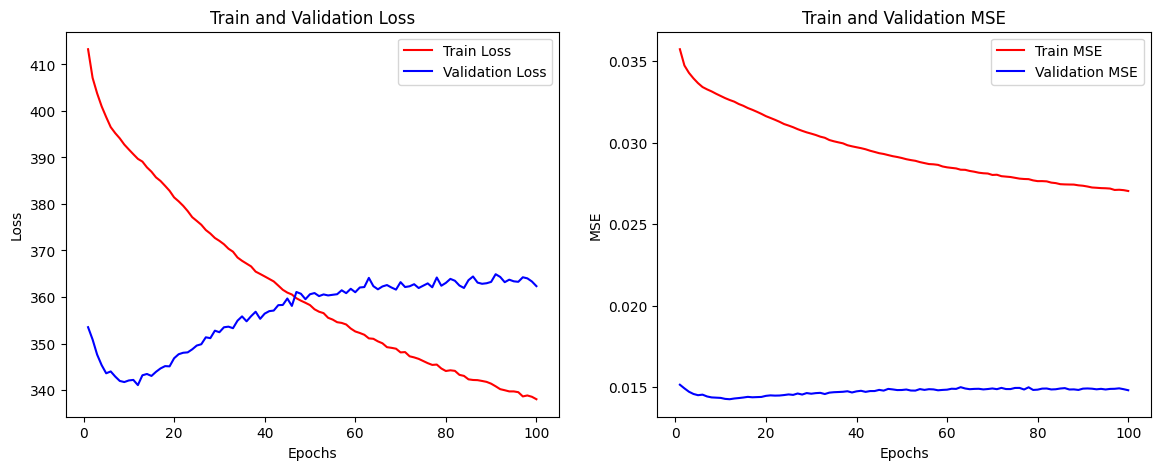

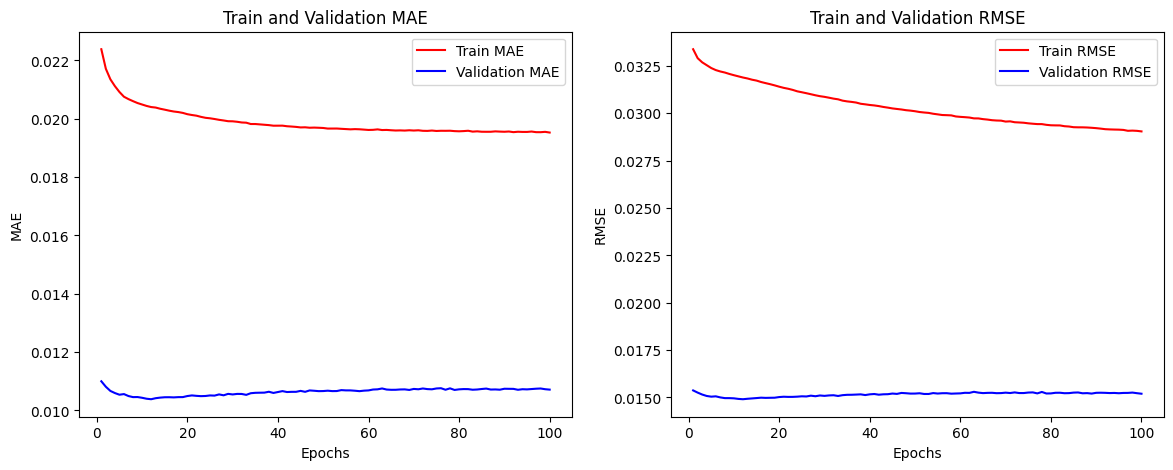

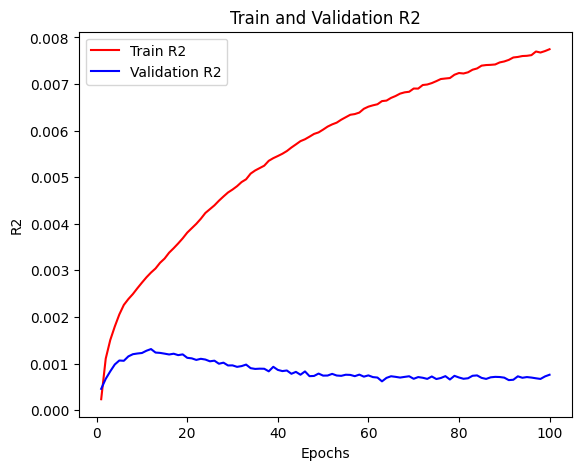

In [29]:
# Plotando a perda e a precisão do modelo sem augmentation
epocas = range(1, epochs + 1) # é 152 epocas porque com early stopping so rodou 152 epocas

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epocas, train_losses, 'r', label='Train Loss')
plt.plot(epocas, val_losses, 'b', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epocas, train_mse, 'r', label='Train MSE')
plt.plot(epocas, val_mse, 'b', label='Validation MSE')
plt.title('Train and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.show()

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epocas, train_mae, 'r', label='Train MAE')
plt.plot(epocas, val_mae, 'b', label='Validation MAE')
plt.title('Train and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epocas, train_rmse, 'r', label='Train RMSE')
plt.plot(epocas, val_rmse, 'b', label='Validation RMSE')
plt.title('Train and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epocas, train_r2, 'r', label='Train R2')
plt.plot(epocas, val_r2, 'b', label='Validation R2')
plt.title('Train and Validation R2')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.legend()

plt.show()

In [30]:
# salvando modelo
torch.save(model.state_dict(), "model/vae.pth")

In [31]:
# carregando modelo
model_path = "model/vae.pth"

# Criar uma instância do modelo
model = TemporalVAE(device, input_dim, hidden_dim, latent_dim, num_layers).to(device)

# Carregar o estado salvo
state_dict = torch.load(model_path)

# Carregar o estado no modelo
model.load_state_dict(state_dict)

<All keys matched successfully>

Average MSE: 0.0298, Average MAE: 0.0216, Average RMSE: 0.0306, Average R²: 0.0015


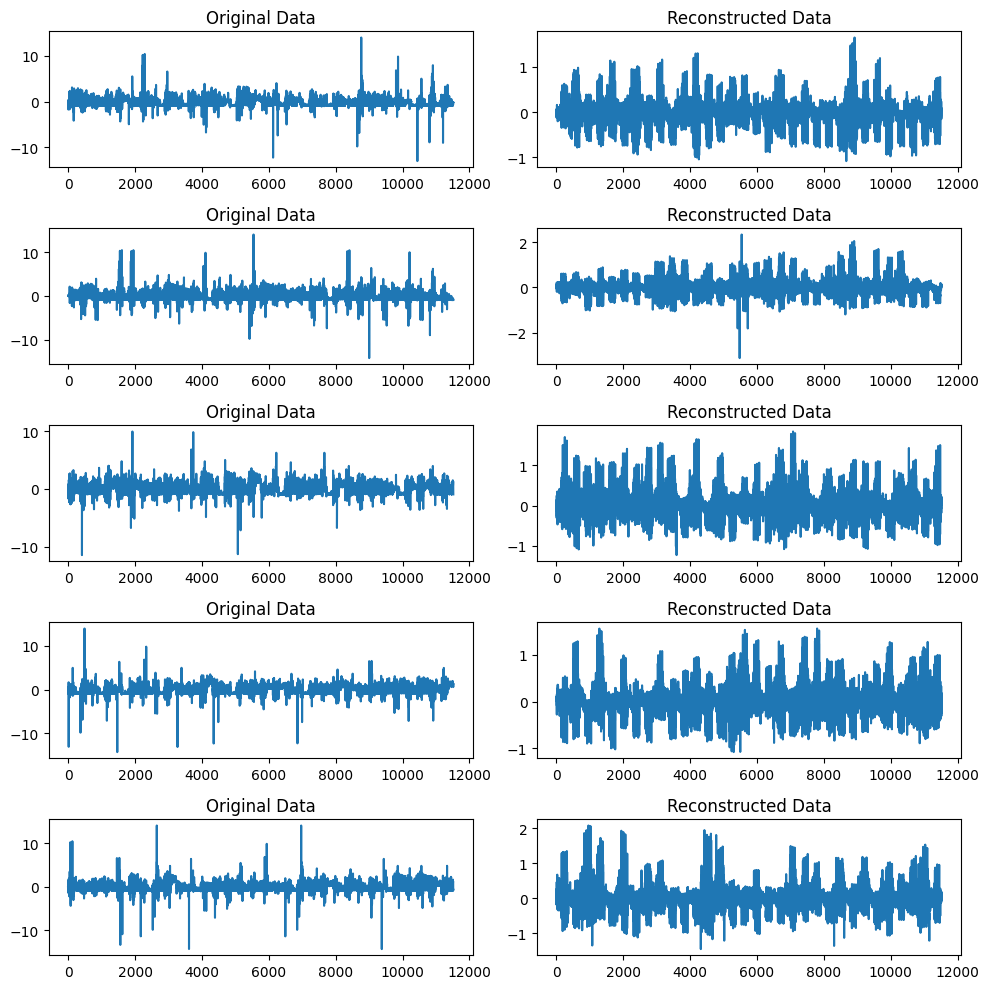

In [32]:
def evaluate_similarity(model, data_loader, device):
    model.eval()
    mse_total = 0
    mae_total = 0
    rmse_total = 0
    r2_total = 0

    with torch.no_grad():
        for x in data_loader:
            data = x.to(device)
            x_hat, _, _ = model(data)
            
            # Calcular métricas de similaridade
            mse, mae, rmse, r2 = evaluate_metrics(data, x_hat)
            mse_total += mse
            mae_total += mae
            rmse_total += rmse
            r2_total += r2

    avg_mse = mse_total / len(data_loader.dataset)
    avg_mae = mae_total / len(data_loader.dataset)
    avg_rmse = rmse_total / len(data_loader.dataset)
    avg_r2 = r2_total / len(data_loader.dataset)

    return avg_mse, avg_mae, avg_rmse, avg_r2

def plot_reconstruction(data_loader, model, device, num_samples=5):
    model.eval()
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))
    with torch.no_grad():
        for i, x in enumerate(data_loader):
            if i >= num_samples:
                break
            data = x.to(device)
            x_hat, _, _ = model(data)
            
            # original = data[0].cpu().numpy()
            # reconstructed = x_hat[0].cpu().numpy()
            original = data.view(-1).detach().cpu().numpy()
            reconstructed = x_hat.view(-1).detach().cpu().numpy()
            
            axs[i, 0].plot(original, label='Original')
            axs[i, 1].plot(reconstructed, label='Reconstructed')
            
            axs[i, 0].set_title('Original Data')
            axs[i, 1].set_title('Reconstructed Data')
    
    plt.tight_layout()
    plt.show()

avg_mse, avg_mae, avg_rmse, avg_r2 = evaluate_similarity(model, test_loader, device)
print(f'Average MSE: {avg_mse:.4f}, Average MAE: {avg_mae:.4f}, Average RMSE: {avg_rmse:.4f}, Average R²: {avg_r2:.4f}')

plot_reconstruction(test_loader, model, device)

In [80]:
# # exemplo de backbone importado para downstrem task

# import torch
# import torch.nn as nn
# import torch.optim as optim

# class Encoder(nn.Module):
#     def __init__(self, input_dim, latent_dim):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 128)
#         self.fc2_mu = nn.Linear(128, latent_dim)
#         self.fc2_logvar = nn.Linear(128, latent_dim)

#     def forward(self, x):
#         h = torch.relu(self.fc1(x))
#         mu = self.fc2_mu(h)
#         logvar = self.fc2_logvar(h)
#         return mu, logvar

# class Decoder(nn.Module):
#     def __init__(self, latent_dim, output_dim):
#         super(Decoder, self).__init__()
#         self.fc3 = nn.Linear(latent_dim, 128)
#         self.fc4 = nn.Linear(128, output_dim)

#     def forward(self, z):
#         h = torch.relu(self.fc3(z))
#         x_recon = torch.sigmoid(self.fc4(h))
#         return x_recon

# class VAE(nn.Module):
#     def __init__(self, input_dim, latent_dim):
#         super(VAE, self).__init__()
#         self.encoder = Encoder(input_dim, latent_dim)
#         self.decoder = Decoder(latent_dim, input_dim)

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def forward(self, x):
#         mu, logvar = self.encoder(x)
#         z = self.reparameterize(mu, logvar)
#         x_recon = self.decoder(z)
#         return x_recon, mu, logvar

# def loss_function(recon_x, x, mu, logvar):
#     BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return BCE + KLD

# # Hyperparameters
# input_dim = 100  # Exemplo, altere de acordo com os seus dados
# latent_dim = 20
# learning_rate = 0.001
# num_epochs = 50

# # Model, optimizer
# vae = VAE(input_dim, latent_dim)
# optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# # Training loop
# for epoch in range(num_epochs):
#     for x in data_loader:  # Assumindo que você tem um data_loader definido
#         optimizer.zero_grad()
#         x_recon, mu, logvar = vae(x)
#         loss = loss_function(x_recon, x, mu, logvar)
#         loss.backward()
#         optimizer.step()
#     print(f'Epoch {epoch}, Loss: {loss.item()}')

# class ActivityClassifier(nn.Module):
#     def __init__(self, encoder, latent_dim, num_classes):
#         super(ActivityClassifier, self).__init__()
#         self.encoder = encoder
#         self.fc = nn.Linear(latent_dim, num_classes)

#     def forward(self, x):
#         mu, logvar = self.encoder(x)
#         return self.fc(mu)  # Utilizando mu como a representação latente

# # Hyperparameters
# num_classes = 10  # Exemplo, altere conforme necessário
# learning_rate = 0.001
# num_epochs = 50

# # Model, optimizer
# activity_classifier = ActivityClassifier(vae.encoder, latent_dim, num_classes)
# optimizer = optim.Adam(activity_classifier.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss()

# # Training loop for the downstream task
# for epoch in range(num_epochs):
#     for x, y in labeled_data_loader:  # Assumindo que você tem um labeled_data_loader definido
#         optimizer.zero_grad()
#         logits = activity_classifier(x)
#         loss = criterion(logits, y)
#         loss.backward()
#         optimizer.step()
#     print(f'Epoch {epoch}, Loss: {loss.item()}')